# <center><u> GRU - 30 Day Rolling prediction (Univariate)

In [1]:
import os
import pandas as pd
import numpy as np
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [3]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [4]:
query="""
    select * 
    from agg.tidy_data_30min
    where site = 64
"""

In [5]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_1294/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [6]:
df.set_index('timestamp', inplace=True)
df = df.sort_index()
df

,site,year,month,day,hour,minute,day_of_week,season,net_load,precipitation,precipitation_probability,wind_direction,wind_speed,solar_radiation,sunshine_duration,avg_net_load,q25_net_load,q75_net_load,median_net_load,weekend_or_bank_holiday
timestamp,,,,,,,,,,,,,,,,,,,,
2019-04-01 00:00:00+00:00,64,2019,4,1,1,0,0,2,14.620,0.0,2.0,97.0,12.0,0.0,0.0,152.86,15.4150,138.56,18.69,0
2019-04-01 00:30:00+00:00,64,2019,4,1,1,30,0,2,16.700,0.0,2.0,97.0,12.0,0.0,0.0,204.52,15.3175,166.11,18.60,0
2019-04-01 01:00:00+00:00,64,2019,4,1,2,0,0,2,20.270,0.0,3.0,99.0,11.0,0.0,0.0,214.66,15.8375,179.70,31.03,0
2019-04-01 01:30:00+00:00,64,2019,4,1,2,30,0,2,15.870,0.0,3.0,99.0,11.0,0.0,0.0,209.72,15.8775,177.33,52.99,0
2019-04-01 02:00:00+00:00,64,2019,4,1,3,0,0,2,15.120,0.0,6.0,100.0,11.0,0.0,0.0,230.59,16.3350,212.62,65.21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 20:30:00+00:00,64,2020,3,31,21,30,1,2,14.390,NaN,NaN,NaN,NaN,NaN,NaN,282.00,15.4650,264.64,19.82,0
2020-03-31 21:00:00+00:00,64,2020,3,31,22,0,1,2,14.710,NaN,NaN,NaN,NaN,NaN,NaN,321.01,14.5975,220.50,16.55,0
2020-03-31 21:30:00+00:00,64,2020,3,31,22,30,1,2,14.950,NaN,NaN,NaN,NaN,NaN,NaN,353.42,14.7625,206.66,30.23,0


In [7]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))

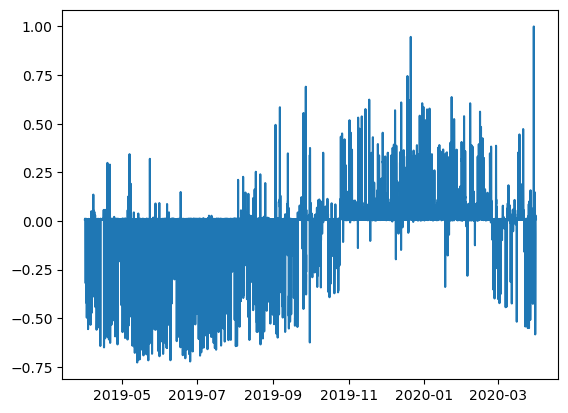

In [8]:
plt.plot(df.index, df.net_load_norm)
plt.show()

## Data Preparation

In [9]:
# Parameters

#n_input = no. of time steps considered before making the prediction
#n_features = no. of variables/features considered
#n_output = no. of time steps to forecast

# Note: 1 time step = 30 mins
# Look at the last two weeks to forecast the next 36 hours

# 1 day = 2 * 24 * 1 = 48
# 6 hours = 2 * 6 = 12 

n_input = 48
n_features = 1
n_output = 12

# Turn net_load_norm into np array
net_load_norm = df['net_load_norm'].to_numpy().reshape(-1, 1)

X, y = [], []
for i in range(len(net_load_norm) - n_input - n_output + 1):
    X.append(net_load_norm[i:(i + n_input), 0])
    y.append(net_load_norm[(i + n_input):(i + n_input + n_output), 0])

X = np.array(X).reshape((len(X), n_input, n_features))
y = np.array(y)

In [10]:
X.shape

(17480, 48, 1)

In [11]:
y.shape

(17480, 12)

In [12]:
print(f'Given the array X: \n {X[0].flatten()}\n')
print(f'Predict this y: \n {y[0]}\n')

Given the array X: 
 [ 0.00781856  0.00893091  0.01084009  0.00848704  0.00808595  0.01163692
  0.01204871  0.00835869  0.0079576   0.00798434  0.00805921  0.00751373
  0.00725169  0.00702173  0.00658855  0.00744956  0.00712334  0.00726238
  0.00750303  0.00727308  0.0073426   0.00754582  0.00788808  0.0072196
  0.0073533  -0.07508918 -0.23238017 -0.25340257 -0.26741929 -0.2747405
 -0.31961431 -0.25242391 -0.10379109  0.00875978  0.00413389  0.00749234
  0.00749234  0.00709125  0.00766347  0.00765277  0.00726773  0.00723564
  0.00812339  0.0079576   0.00774369  0.00798969  0.00802712  0.00760464]

Predict this y: 
 [0.00853517 0.01157275 0.00923039 0.00780786 0.00840682 0.00905391
 0.00823569 0.00859934 0.00782391 0.0080806  0.00852982 0.00703242]



In [13]:
print(f'Given the array X: \n {X[1].flatten()}\n')
print(f'Predict this y: \n {y[1]}\n')

Given the array X: 
 [ 0.00893091  0.01084009  0.00848704  0.00808595  0.01163692  0.01204871
  0.00835869  0.0079576   0.00798434  0.00805921  0.00751373  0.00725169
  0.00702173  0.00658855  0.00744956  0.00712334  0.00726238  0.00750303
  0.00727308  0.0073426   0.00754582  0.00788808  0.0072196   0.0073533
 -0.07508918 -0.23238017 -0.25340257 -0.26741929 -0.2747405  -0.31961431
 -0.25242391 -0.10379109  0.00875978  0.00413389  0.00749234  0.00749234
  0.00709125  0.00766347  0.00765277  0.00726773  0.00723564  0.00812339
  0.0079576   0.00774369  0.00798969  0.00802712  0.00760464  0.00853517]

Predict this y: 
 [0.01157275 0.00923039 0.00780786 0.00840682 0.00905391 0.00823569
 0.00859934 0.00782391 0.0080806  0.00852982 0.00703242 0.00748164]



# Train and Test Set Split

In [14]:
# 1 time step = 30 mins

n_split = 2 * 24 * 300 

X_train = X[:n_split]
y_train = y[:n_split]

X_test = X[n_split:]
y_test = y[n_split:]

In [15]:
X_train.shape

(14400, 48, 1)

In [16]:
y_train.shape

(14400, 12)

In [17]:
X_test.shape

(3080, 48, 1)

In [18]:
y_test.shape

(3080, 12)

## GRU Model

### Model 1:

In [19]:
model1 = Sequential()
model1.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model1.add(GRU(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(y_train.shape[1]))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 48, 64)            12864     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 12)                396       
                                                                 
Total params: 22,668
Trainable params: 22,668
Non-trainable params: 0
_________________________________________________________________


In [20]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss='mse', optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError(), MeanAbsoluteError()])

In [21]:
history = model1.fit(X_train, y_train, epochs=10, callbacks=[cp1], batch_size=16, validation_split=0.1)

Epoch 1/10


2024-03-29 15:08:14.813952: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


810/810 [==============================] - 10s 11ms/step - loss: 0.0245 - mean_squared_error: 0.0245 - mean_absolute_error: 0.0878 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0828
Epoch 2/10
810/810 [==============================] - 9s 11ms/step - loss: 0.0205 - mean_squared_error: 0.0205 - mean_absolute_error: 0.0831 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0807
Epoch 3/10
810/810 [==============================] - 9s 11ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.0799 - val_loss: 0.0159 - val_mean_squared_error: 0.0159 - val_mean_absolute_error: 0.0716
Epoch 4/10
810/810 [==============================] - 9s 11ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0787 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0687
Epoch 5/10
810/810 [==============================] - 9s 11ms/step - loss: 0.0175 - mean_squared_error

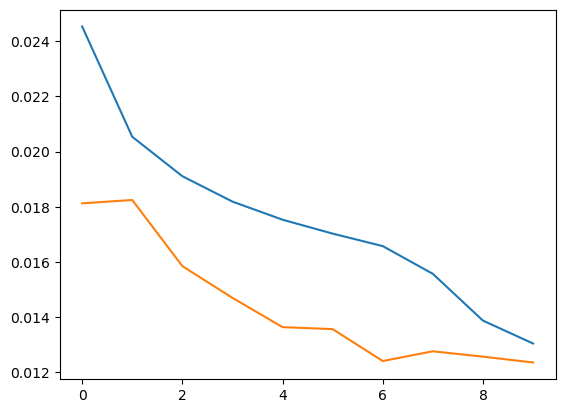

In [23]:
#Checking Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

#### Training Results

In [24]:
# Select every n_output-th sample 

# This will be the inputs into the LSTM model

X_train_input = X_train[::n_output]
y_train_input = y_train[::n_output]

In [25]:
X_train_input.shape

(1200, 48, 1)

In [26]:
y_train_input.shape

(1200, 12)

1/1 [==============================] - 0s 13ms/step


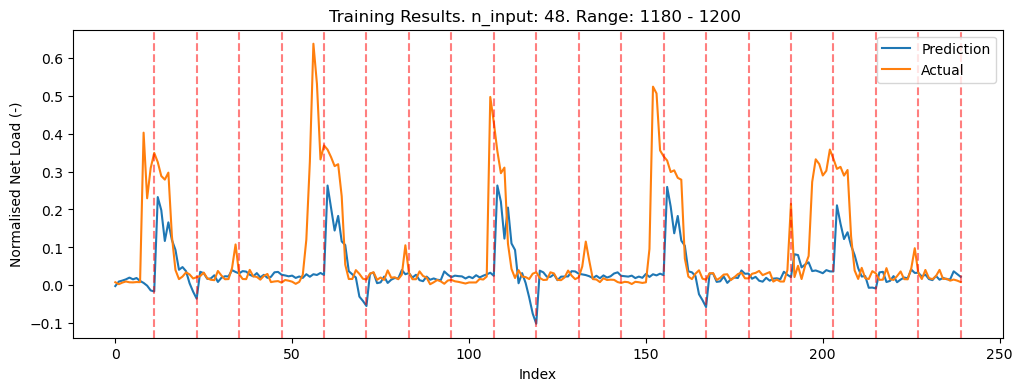

In [27]:
# Parameters to change to better visualise the training results

# 1 = n_output e.g., 24 hours or maybe 1 week depending

start_section = 1180
end_section = 1200
diff = end_section-start_section


predictions = []

for i in X_train_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)
    prediction = model1.predict(i_reshaped)

    prediction_list = list(prediction[0])
    predictions.append(prediction_list)

plt.figure(figsize=(12,4))
plt.title(f"Training Results. n_input: {n_input}. Range: {start_section} - {end_section} ")
plt.plot(np.array(predictions).flatten(), label='Prediction')
plt.plot(y_train_input[start_section:end_section].flatten(), label = 'Actual')
plt.xlabel('Index')
plt.ylabel('Normalised Net Load (-)')

xcoords = [(i*n_output)-1+n_output for i in range(diff)]
for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)


plt.legend()

#### Test Results

In [28]:
# Select every n_output-th sample 

# This will be the inputs into the LSTM model

X_test_input = X_test[::n_output]
y_test_input = y_test[::n_output]

In [29]:
X_test_input.shape

(257, 48, 1)

In [30]:
y_test_input.shape

(257, 12)

1/1 [==============================] - 0s 13ms/step


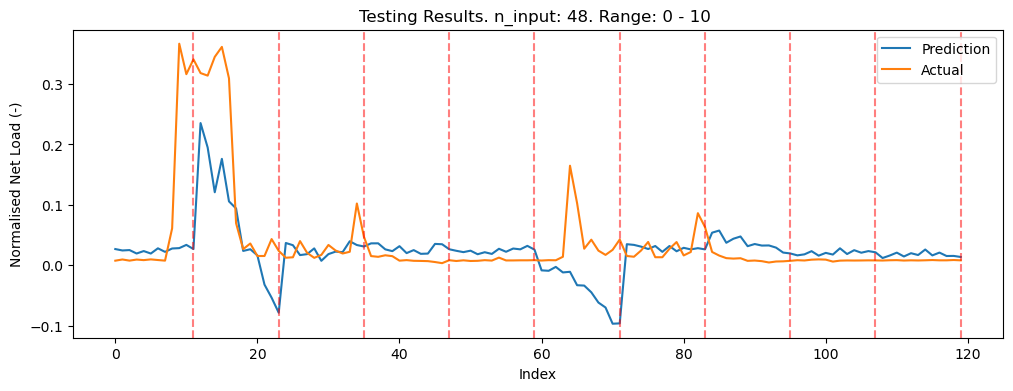

In [31]:
# Parameters to change to better visualise the training results

# 1 = n_output e.g., 24 hours or maybe 1 week depending

start_section = 0
end_section = 10
diff = end_section-start_section


predictions = []

for i in X_test_input[start_section:end_section]:
    i_reshaped = i.reshape(1, n_input, n_features)
    prediction = model1.predict(i_reshaped)

    prediction_list = list(prediction[0])
    predictions.append(prediction_list)

plt.figure(figsize=(12,4))
plt.title(f"Testing Results. n_input: {n_input}. Range: {start_section} - {end_section} ")
plt.plot(np.array(predictions).flatten(), label='Prediction')
plt.plot(y_test_input[start_section:end_section].flatten(), label = 'Actual')
plt.xlabel('Index')
plt.ylabel('Normalised Net Load (-)')

xcoords = [(i*n_output)-1+n_output for i in range(diff)]
for xc in xcoords:
    plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)


plt.legend()